# Building a Movies Recommendation Engine
“What movie should I watch this evening?” — have you ever had to answer this question at least once when you came home from work? As for me — yes, and more than once. From Netflix to Hulu, the need to build robust movie recommendation systems is extremely important given the huge demand for personalized content of modern consumers.

In this notebook, I will attempt at implementing a few algorithms (content based and collaborative filtering) to recommend movies and evaluate them to see which one performs better.

After reading this post you will know:

* About the MovieLens dataset 
* How to load then understand the data.
* How to do exploratory data analysis.
* The 2 different types of recommendation engines.
* How to develop a content-based recommendation model for the MovieLens dataset.
* How to develop a collaborative filtering model for the MovieLens dataset.
* How to evaluate these models based on precision and recall.
* Suggestions to improve the model accuracy.

Let’s get started.

## The MovieLens Dataset
One of the most common datasets that is available on the internet for building a Recommender System is the [MovieLens DataSet](https://grouplens.org/datasets/movielens/). This version of the dataset that I'm working with ([1M](https://grouplens.org/datasets/movielens/1m/)) contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

The data was collected by GroupLens researchers over various periods of time, depending on the size of the set. This 1M version was released on February 2003. Users were selected at random for inclusion. All users selected had rated at least 20 movies. Each user is represented by an id, and no other information is provided.

The original data are contained in three files, [movies.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/movies.dat), [ratings.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/ratings.dat) and [users.dat](https://github.com/khanhnamle1994/movielens/blob/master/dat/users.dat). To make it easier to work with the data, I used a [script](https://github.com/khanhnamle1994/movielens/blob/master/dat_to_csv.py) to convert the .dat files into [.csv files](https://github.com/khanhnamle1994/movielens/tree/master/csv).

## Data Preparation
Let's load this data into Python. I will load the dataset with Pandas onto Dataframes **ratings**, **users**, and **movies**. Before that, I'll also pass in column names for each CSV and read them using pandas (the column names are available in the [Readme](https://github.com/khanhnamle1994/movielens/blob/master/README.md) file).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
r_cols = ['user_id', 'movie_id', 'rating', 'ts']
ratings = pd.read_csv('csv/ratings.csv', names=r_cols, encoding='latin-1')

# Reading users file
u_cols = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_csv('csv/users.csv', names=u_cols, encoding='latin-1')

# Reading movies file
m_cols = ['movie_id', 'title' ,'genres']
movies = pd.read_csv('csv/movies.csv', names=m_cols, encoding='latin-1')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Now lets take a peak into the content of each file to understand them better.

### Ratings Dataset

In [2]:
print(ratings.shape)

(1000210, 4)


In [3]:
print(ratings.head())

   user_id  movie_id  rating         ts
0  user_id  movie_id  rating         ts
1        1      1193       5  978300760
2        1       661       3  978302109
3        1       914       3  978301968
4        1      3408       4  978300275


In [4]:
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000210 entries, 0 to 1000209
Data columns (total 4 columns):
user_id     1000210 non-null object
movie_id    1000210 non-null object
rating      1000210 non-null object
ts          1000210 non-null object
dtypes: object(4)
memory usage: 30.5+ MB
None


This confirms that there are 1M ratings for different user and movie combinations. Also notice that each rating has a timestamp (ts) associated with it.

### Users Dataset

In [5]:
print(users.shape)

(6041, 5)


In [6]:
print(users.head())

   user_id  gender  age  occupation    zip
0  user_id  gender  age  occupation    zip
1        1       F    1          10  48067
2        2       M   56          16  70072
3        3       M   25          15  55117
4        4       M   45           7  02460


In [7]:
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6041 entries, 0 to 6040
Data columns (total 5 columns):
user_id       6041 non-null object
gender        6041 non-null object
age           6041 non-null object
occupation    6041 non-null object
zip           6041 non-null object
dtypes: object(5)
memory usage: 236.1+ KB
None


This confirms that there are 6041 users and we have 5 features for each (unique user ID, gender, age, occupation and the zip code they are living in).

### Movies Dataset

In [8]:
print(movies.shape)

(3884, 3)


In [9]:
print(movies.head())

   movie_id                     title                        genres
0  movie_id                     title                        genres
1         1          Toy Story (1995)   Animation|Children's|Comedy
2         2            Jumanji (1995)  Adventure|Children's|Fantasy
3         3   Grumpier Old Men (1995)                Comedy|Romance
4         4  Waiting to Exhale (1995)                  Comedy|Drama


In [10]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3884 entries, 0 to 3883
Data columns (total 3 columns):
movie_id    3884 non-null object
title       3884 non-null object
genres      3884 non-null object
dtypes: object(3)
memory usage: 91.1+ KB
None


This dataset contains attributes of the 3884 movies. There are 3 columns including the movie ID, their titles, and their genres. Genres are pipe-separated and are selected from 18 genres (Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western).

In order to work with the data easier, I first remove unuseful features including timestamps, occupation and zip-code. Then I merge the 3 dataframes into a single one, calling it *dataset*.

In [11]:
# Remove the features that are not useful
ratings = ratings.drop(['ts'], axis=1)
users = users.drop(['occupation'], axis=1)
users = users.drop(['zip'], axis=1)

In [12]:
# Create one data frame from the three
dataset = pd.merge(pd.merge(movies, ratings),users)
print(dataset.head())

   movie_id                                      title  \
0  movie_id                                      title   
1         1                           Toy Story (1995)   
2        48                          Pocahontas (1995)   
3       150                           Apollo 13 (1995)   
4       260  Star Wars: Episode IV - A New Hope (1977)   

                                 genres  user_id  rating  gender  age  
0                                genres  user_id  rating  gender  age  
1           Animation|Children's|Comedy        1       5       F    1  
2  Animation|Children's|Musical|Romance        1       5       F    1  
3                                 Drama        1       5       F    1  
4       Action|Adventure|Fantasy|Sci-Fi        1       4       F    1  


## Data Exploration
### Titles
Are there certain words that figure more often in Movie Titles? I'll attempt to figure this out using a word-cloud visualization.

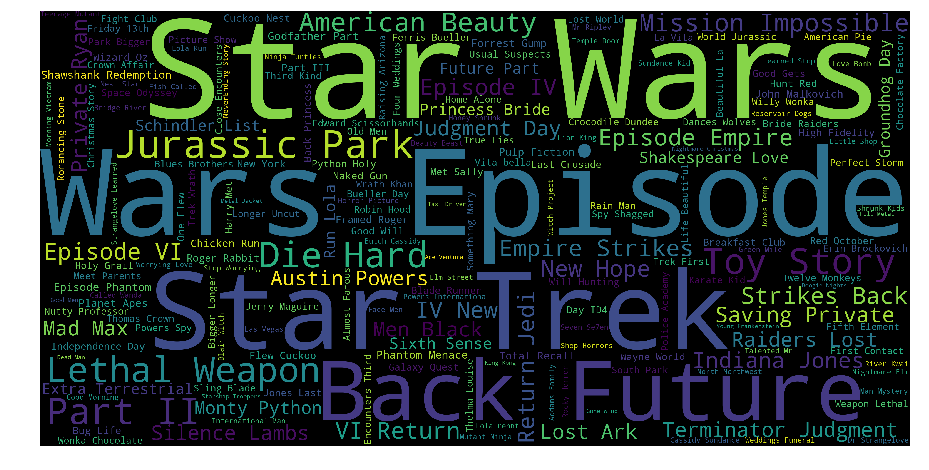

In [13]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
dataset['title'] = dataset['title'].astype('str')
title_corpus = ' '.join(dataset['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Beautiful, isn't it? I can recognize that there are a lot of movie franchises in this dataset, such as Mission Impossible, Star Trek, Star Wars, Toy Story, Die Hard, Jurassic Park, Indiana Jones... In addition to that, *Wars*, *Back*, *Future*, *Episode*, *Part II* are mong the most commonly occuring words.

### Ratings
Next I want to examine the **rating** further. Let's take a look at its summary statistics and distribution.

In [14]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

# Convert rating into numeric value
dataset['rating'] = dataset['rating'].apply(clean_numeric).astype('float')
# Get summary statistics of rating
dataset['rating'].describe()

count    131071.000000
mean          3.598012
std           1.112963
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

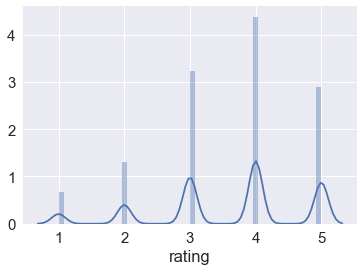

In [15]:
%matplotlib inline
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Display distribution of rating
sns.distplot(dataset['rating'].fillna(dataset['rating'].median()))

It appears that users are quite generous in their ratings. The mean rating is 3.59 on a scale of 5. Half the movies have a rating of 4 and 5. I personally think that a 5-level rating skill wasn’t a good indicator as people could have different rating styles (i.e. person A could always use 4 for an average movie, whereas person B only gives 4 out for their favorites). Each user rated at least 20 movies, so I doubt the distribution could be caused just by chance variance in the quality of movies.

Let's also take a look at a subset of 10 movies with the highest rating.

In [16]:
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(10)

,title,genres,rating
1,Toy Story (1995),Animation|Children's|Comedy,5.0
91390,Cape Fear (1962),Film-Noir|Thriller,5.0
91388,Indiana Jones and the Last Crusade (1989),Action|Adventure,5.0
31670,Big Night (1996),Drama,5.0
91386,Evil Dead II (Dead By Dawn) (1987),Action|Adventure|Comedy|Horror,5.0
91385,Terminator` The (1984),Action|Sci-Fi|Thriller,5.0
91384,Full Metal Jacket (1987),Action|Drama|War,5.0
91381,Psycho (1960),Horror|Thriller,5.0
91379,Army of Darkness (1993),Action|Adventure|Comedy|Horror|Sci-Fi,5.0
91378,Alien (1979),Action|Horror|Sci-Fi|Thriller,5.0


### Genres
The genres variable will surely be important while building the recommendation engines since it describes the content of the film (i.e. Animation, Horror, Sci-Fi). A basic assumption is that films in the same genre should have similar contents. I'll attempt to see exactly which genres are the most popular.

In [17]:
# Make a census of the genre keywords
genre_labels = set()
for s in dataset['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [18]:
# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(dataset, 'genres', genre_labels)
keyword_occurences[:5]

[['Comedy', 47773],
 ['Drama', 45404],
 ['Action', 34885],
 ['Thriller', 24703],
 ['Sci-Fi', 20987]]

The top 5 genres are, in that respect order: Comedy, Drama, Action, Thriller, and Sci-Fi. I'll show this on a wordcloud too in order to make it more visually appealing.

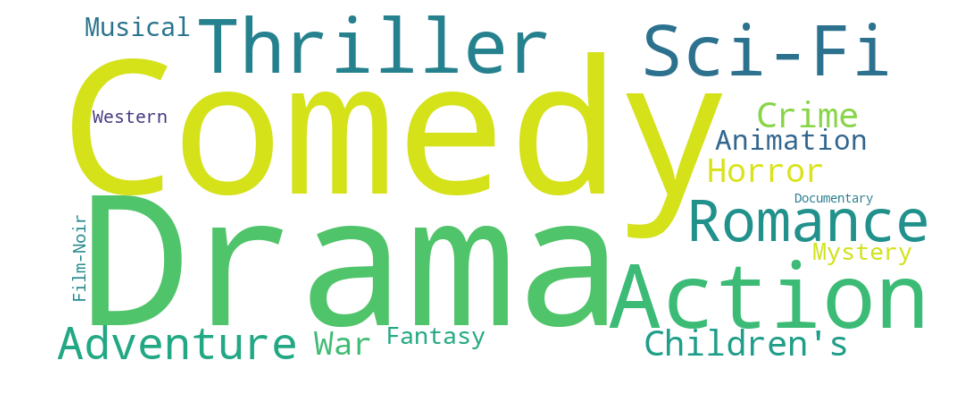

In [19]:
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Types of Recommendation Engines

### 1. Content-Based
The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

### 2. Collaborative Filtering
The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that. For instance, if a person A likes item 1, 2, 3 and a person B likes item 2,3,4, then they have similar interests and A should like item 4 and B should like item 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

## Content-Based Recommendation Model
I am going to build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. In particular, I will build a Content-Based Recommender based on the movie genres.

In [20]:
# Break up the big string into a string array
dataset['genres'] = dataset['genres'].str.split('|')
# Convert genres to string value
dataset['genres'] = dataset['genres'].astype('str')

I do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively. In order to do so, I'll use **TfidfVectorizer** function from **scikit-learn**, which transforms text to feature vectors that can be used as input to estimator.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(dataset['genres'])
tfidf_matrix.shape

(131072, 127)

I will be using the **[Cosine Similarity](https://masongallo.github.io/machine/learning,/python/2016/07/29/cosine-similarity.html)** to calculate a numeric quantity that denotes the similarity between two movies. Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

I now have a pairwise cosine similarity matrix for all the movies in the dataset. The next step is to write a function that returns the 20 most similar movies based on the cosine similarity score.

In [ ]:
dataset = dataset.reset_index()
titles = dataset['title']
indices = pd.Series(dataset.index, index=dataset['title'])

# Function that get movie recommendations based on their cosine similarity score
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Let's try and get the top recommendations for a few movies and see how good the recommendations are.

In [ ]:
get_recommendations('Saving Private Ryan').head(10)

In [ ]:
get_recommendations('American Beauty').head(10)

In [ ]:
get_recommendations('Shawshank Redemption').head(10)

## Collaborative Filtering Recommendation Model

## Evaluating Recommendation Models

## Suggestions to Improve Model Accuracy

## Summary
**Content-Based Recommendation**:
* The major advantage on content based approach is its ability to recommend previously unrated item to users. Unlike collaborating filtering, content based approach are able to effectively recommend unrated items and provide quality recommendation to users with unique taste.
* The main disadvantage of this approach is each item in the entire system must have a precise description such that the system can recommend accurately. And also, they are not capable of filtering items on some assessment of quality, style or viewpoint because of lack of consideration of other people’s experience. Content based approach can’t recommend serendipitous items. That means user are generally recommended items of that are similar in context. The other disadvantage with such system is the problem of synonymy. There are many different keywords having same meaning, they are treated as independent words by content filtering approach such that no similarity can be obtained in user’s profile and item profile.